In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read the Datasets

In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
#sample of dataset
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### Check the shape of the raw input dataset

In [4]:
df.shape

(28619, 3)

### Check column names, datatypes and descripitions

In [5]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [6]:
df.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

In [7]:
df['is_sarcastic'].unique()

array([1, 0], dtype=int64)

There are 3 columns avaialble:
1.  is_sarcastic: It is a flag variable having 1 indicating the record is sarcastic and 0 for otherwise.
2.	headline: It contains the actual news headline from the news article.
3.	article_link: It contains links to the original news article, which can be used to collect supplementary data if required.


### Check the Class Balance or Inbalance in the dataset

In [8]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

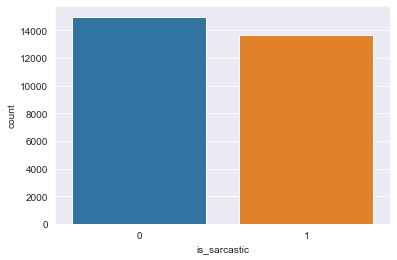

In [9]:
sns.set_style("darkgrid")
sns.countplot(df.is_sarcastic)

In [10]:
print("Percentage of non-sarcastic headlines=","{:.2f}".format(df['is_sarcastic'].value_counts()[0]/df.shape[0]*100),"%")
print("Percentage of sarcastic headlines=","{:.2f}".format(df['is_sarcastic'].value_counts()[1]/df.shape[0]*100),"%")

Percentage of non-sarcastic headlines= 52.36 %
Percentage of sarcastic headlines= 47.64 %


The 2 classes available i.e. sarcasrtic and non-sarcatic are very well balanced.

Therefore, no need for any class imbalancement techniques required.

### Check for any Null values in the dataset

In [11]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

There are no Null values present in the dataset

### Check for any duplicate headline text

In [12]:
df['article_link'].nunique()

28617

In [13]:
df.duplicated().sum()

2

There are 2 duplicate rows/headlines present. We need to remove the duplicates. 

### Remove duplicate rows

In [14]:
#Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

In [15]:
#No duplicated found
df.duplicated().sum()

0

## Checking the most frequent words before cleaning

Dividing the datasets into 2 sets containing sarcastic and non-sarcastic headlines respectively for analysis.

In [16]:
df_cleaned_sarcastic=df[df['is_sarcastic']==1]
df_cleaned_non_sarcastic=df[df['is_sarcastic']==0]

#### Top 10 Frequent words for Sarcastic Dataset

In [17]:
from collections import Counter
corpus_sarcastic=" ".join(df_cleaned_sarcastic['headline'])
corpus_split=corpus_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('to', 4980),
 ('of', 3790),
 ('in', 2104),
 ('for', 1736),
 ('on', 1286),
 ('man', 1143),
 ('with', 1008),
 ('new', 973),
 ('by', 730),
 ('the', 688)]

#### Top 10 Frequent words for Non-Sarcastic Dataset

In [18]:
from collections import Counter
corpus_non_sarcastic=" ".join(df_cleaned_non_sarcastic['headline'])
corpus_split=corpus_non_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('the', 4593),
 ('to', 4065),
 ('of', 2462),
 ('a', 2443),
 ('in', 2417),
 ('for', 1881),
 ('and', 1631),
 ('is', 1494),
 ('on', 1318),
 ('trump', 957)]

Here we can see that before cleaning, most frequent words are consisiting of stop words. So we need to clean the data and check the frequent words again.

## Data Cleaning

## Step 1:
### Remove Special Characters
### Remove numbers if not required
### Remove word anomalies like 1a, 2b, etc.

In [19]:
%%time
df1=df.copy()

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"[^\w\s]"," ",str(x)))

#Remove all numbers
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d',"",str(x)))

#Remove word anomalies
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d{1}[a-z]',"",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 259 ms


## Step 2:
### Convert to lower case
### Remove Stopwords and special words that need to be removed
### Perform Lemmatization
### Remove all single letter words
### Remove extra spaces

In [20]:
%%time
stop=set(stopwords.words('english'))
#Update any words that we want to remove here
custom_list=['nan']
stop.update(custom_list)

tadDict = defaultdict(lambda : wn.NOUN)
tadDict['J'] = wn.ADJ
tadDict['V'] = wn.VERB
tadDict['R'] = wn.ADV

#Convert to lower case
df1['headline']=df1['headline'].apply(lambda x: x.lower())

#Remove stopwords
df1['headline']=df1['headline'].apply(lambda x: " ".join([i for i in word_tokenize(x) if i.casefold() not in map(str.casefold,stop)]))

#Perform Lemmatization
df1['headline']=df1['headline'].apply(lambda x: " ".join(WordNetLemmatizer().lemmatize(word,tadDict[tag[0]]) for word,tag in pos_tag(word_tokenize(x))))

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"( [a-z]{1} )|(^[a-z]{1} )|( [a-z]{1}$)"," ",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 49.6 s


## Raw vs Cleaned data sample

In [21]:
df1['raw_headline']=df['headline']
df1[['raw_headline','headline']]

,raw_headline,headline
0,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist unveil doomsday cloc...
1,dem rep. totally nails why congress is falling...,dem rep totally nails congress fall short gend...
2,eat your veggies: 9 deliciously different recipes,eat veggie deliciously different recipe
3,inclement weather prevents liar from getting t...,inclement weather prevents liar get work
4,mother comes pretty close to using word 'strea...,mother come pretty close use word stream corre...
...,...,...
28614,jews to celebrate rosh hashasha or something,jew celebrate rosh hashasha something
28615,internal affairs investigator disappointed con...,internal affair investigator disappoint conspi...
28616,the most beautiful acceptance speech this week...,beautiful acceptance speech week come queer ko...
28617,mars probe destroyed by orbiting spielberg-gat...,mar probe destroy orbit spielberg gate space p...


## Checking the most frequent words after cleaning

Dividing the datasets into 2 sets containing sarcastic and non-sarcastic headlines respectively for analysis.

In [22]:
df_cleaned=df1.copy()

In [23]:
df_cleaned_sarcastic=df_cleaned[df_cleaned['is_sarcastic']==1]
df_cleaned_non_sarcastic=df_cleaned[df_cleaned['is_sarcastic']==0]

#### Top 10 Frequent words for Sarcastic Dataset

In [24]:
from collections import Counter
corpus_sarcastic=" ".join(df_cleaned_sarcastic['headline'])
corpus_split=corpus_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('man', 1288),
 ('new', 1010),
 ('report', 581),
 ('get', 544),
 ('area', 493),
 ('woman', 487),
 ('year', 473),
 ('nation', 391),
 ('trump', 385),
 ('go', 373)]

#### Top 10 Frequent words for Non-Sarcastic Dataset

In [25]:
from collections import Counter
corpus_non_sarcastic=" ".join(df_cleaned_non_sarcastic['headline'])
corpus_split=corpus_non_sarcastic.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(10)
most_occur

[('trump', 1450),
 ('new', 686),
 ('say', 546),
 ('woman', 479),
 ('make', 465),
 ('get', 464),
 ('donald', 458),
 ('year', 381),
 ('one', 272),
 ('day', 269)]

## Length of characters in texts

Average length of characters in sarcastic= 65.33103498863053
Average length of characters in non-sarcastic= 59.56079818473038


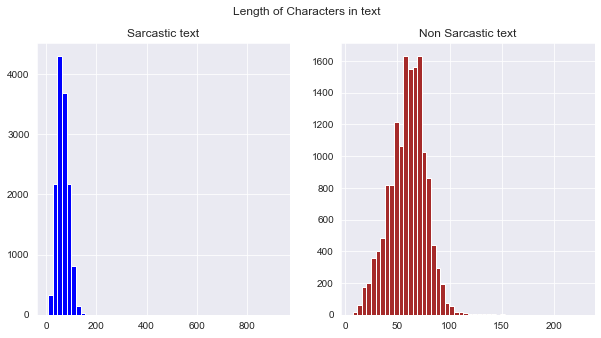

In [26]:
fig,(plot1,plot2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
print("Average length of characters in sarcastic=",text_len.mean())
plot1.hist(text_len,bins=50,color='blue')
plot1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
print("Average length of characters in non-sarcastic=",text_len.mean())
plot2.hist(text_len,bins=50,color='brown')
plot2.set_title('Non Sarcastic text')
fig.suptitle('Length of Characters in text')
plt.show()

## Number of words in each text

Average number of words in sarcastic= 10.307489180664565
Average number of words in non-sarcastic= 9.816003737319807


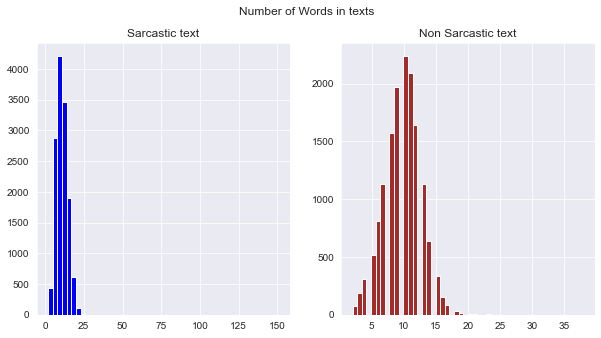

In [27]:
fig,(plot1,plot2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
print("Average number of words in sarcastic=",text_len.mean())
plot1.hist(text_len,bins=50, color='blue')
plot1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
print("Average number of words in non-sarcastic=",text_len.mean())
plot2.hist(text_len,bins=50,color='brown')
plot2.set_title('Non Sarcastic text')
fig.suptitle('Number of Words in texts')
plt.show()

## Average length of the words present in the text

Average length of words for sarcastic= 5.548901501652932
Average length of words for non-sarcastic= 5.24789908552831


Text(0.5, 0.98, 'Average word length in each text')

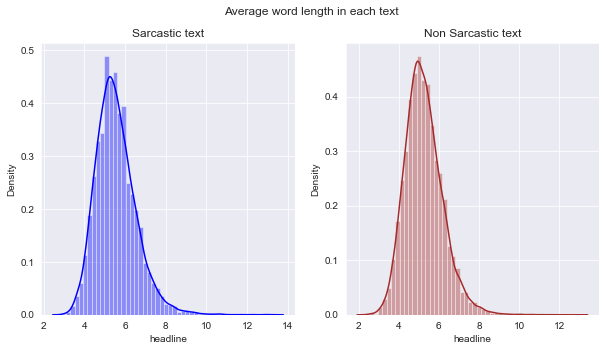

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
print("Average length of words for sarcastic=",word.map(lambda x: np.mean(x)).mean())
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Sarcastic text')

word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
print("Average length of words for non-sarcastic=",word.map(lambda x: np.mean(x)).mean())
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='brown')
ax2.set_title('Non Sarcastic text')

fig.suptitle('Average word length in each text')

## Creating Word Cloud

In [29]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

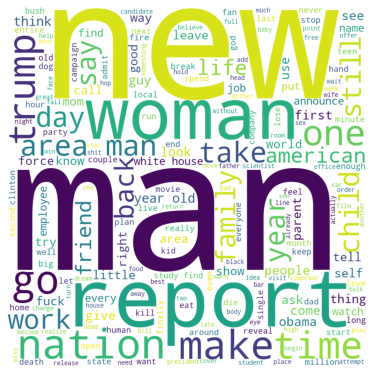

In [30]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus_sarcastic) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

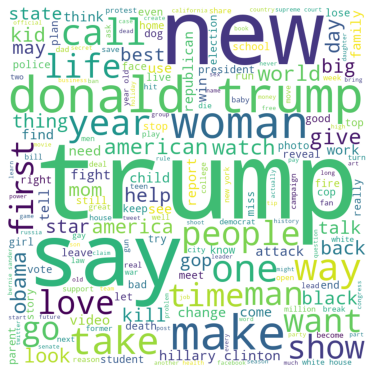

In [31]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus_non_sarcastic) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 